In [ ]:
pip install tensorflow google-genai

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

try:
    from groq import Groq
    print("Groq library imported successfully")
except ImportError as e:
    print(f"Error importing Groq: {e}")
    !pip install --upgrade groq
    from groq import Groq

Error importing Groq: No module named 'groq'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 7.1 MB/s eta 0:00:00


In [6]:
import os
from dotenv import load_dotenv

load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
MODEL_NAME = "llama-3.3-70b-versatile"

VOCAB_SIZE = 8000
MAX_LEN = 180
EMBEDDING_DIM = 100
LSTM_UNITS = 96
DROPOUT_RATE = 0.35
SPATIAL_DROPOUT = 0.35
RECURRENT_DROPOUT = 0.25
LEARNING_RATE = 0.0003
BATCH_SIZE = 128
EPOCHS = 6
TRAIN_SPLIT = 0.9
VAL_SPLIT = 0.1

print("=" * 60)
print("FAST & ACCURATE SENTIMENT ANALYSIS PIPELINE")
print("=" * 60)
print(f"Teacher Model: {MODEL_NAME}")
print(f"Vocabulary Size: {VOCAB_SIZE}")
print(f"Max Sequence Length: {MAX_LEN}")
print(f"Embedding Dimension: {EMBEDDING_DIM}")
print(f"LSTM Units: {LSTM_UNITS}")
print(f"Training Split: {int(TRAIN_SPLIT*100)}% train / {int(VAL_SPLIT*100)}% validation")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")

FAST & ACCURATE SENTIMENT ANALYSIS PIPELINE
Teacher Model: llama-3.3-70b-versatile
Vocabulary Size: 8000
Max Sequence Length: 180
Embedding Dimension: 100
LSTM Units: 96
Training Split: 90% train / 10% validation
Epochs: 6
Batch Size: 128


In [7]:
print("\n[1/6] Loading IMDB Dataset with 90-10 Split...")
(x_full_train, y_full_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

total_samples = len(x_full_train)
train_size = int(total_samples * TRAIN_SPLIT)

x_train = x_full_train[:train_size]
y_train = y_full_train[:train_size]
x_val = x_full_train[train_size:]
y_val = y_full_train[train_size:]

print(f"✓ Total available samples: {total_samples}")
print(f"✓ Training samples (90%): {len(x_train)}")
print(f"✓ Validation samples (10%): {len(x_val)}")
print(f"✓ Testing samples: {len(x_test)}")

word_index = imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])

print("✓ Word index loaded")


[1/6] Loading IMDB Dataset with 90-10 Split...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Total available samples: 25000
✓ Training samples (90%): 22500
✓ Validation samples (10%): 2500
✓ Testing samples: 25000
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Word index loaded


In [8]:
print("\n[2/6] Preprocessing sequences...")
x_train_pad = pad_sequences(x_train, maxlen=MAX_LEN)
x_val_pad = pad_sequences(x_val, maxlen=MAX_LEN)
x_test_pad = pad_sequences(x_test, maxlen=MAX_LEN)

print(f"✓ Training shape: {x_train_pad.shape}")
print(f"✓ Validation shape: {x_val_pad.shape}")
print(f"✓ Testing shape: {x_test_pad.shape}")


[2/6] Preprocessing sequences...
✓ Training shape: (22500, 180)
✓ Validation shape: (2500, 180)
✓ Testing shape: (25000, 180)


In [9]:
print("\n[3/6] Initializing Groq LLM Teacher Model...")
client = Groq(api_key=GROQ_API_KEY)

def get_llm_sentiment(review_text):
    prompt = f"Identify sentiment (1=Positive, 0=Negative). Reply ONLY with the number 1 or 0. Review: {review_text}"
    chat_completion = client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}],
        model=MODEL_NAME,
        temperature=0.0,
        max_tokens=10
    )
    response_text = chat_completion.choices[0].message.content.strip()
    try:
        return int(response_text)
    except:
        return 1 if 'positive' in response_text.lower() or '1' in response_text else 0

def evaluate_llm_accuracy(num_samples=50):
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    correct = 0
    for idx in indices:
        raw_text = decode_review(x_test[idx])
        try:
            llm_pred = get_llm_sentiment(raw_text[:400])
            if llm_pred == y_test[idx]:
                correct += 1
        except:
            pass
    accuracy = correct / num_samples
    print(f"✓ LLM Teacher Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    return accuracy

print(f"✓ Groq client ready using model: {MODEL_NAME}")


[3/6] Initializing Groq LLM Teacher Model...
✓ Groq client ready using model: llama-3.3-70b-versatile


In [10]:
print("\n[4/6] Building Optimized LSTM Student Model...")

def build_tuned_lstm():
    model = models.Sequential([
        layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
        layers.SpatialDropout1D(SPATIAL_DROPOUT),
        layers.Bidirectional(layers.LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=RECURRENT_DROPOUT, return_sequences=True)),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(1, activation='sigmoid')
    ])
    opt = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = build_tuned_lstm()
model.build(input_shape=(None, MAX_LEN))
model.summary()
print(f"\n✓ Total Trainable Parameters: {model.count_params():,}")


[4/6] Building Optimized LSTM Student Model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 180, 100)       │       800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 180, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 180, 192)       │       151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 192)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 963,713 (3.68 MB)

 Trainable params: 963,713 (3.68 MB)

 Non-trainable params: 0 (0.00 B)


✓ Total Trainable Parameters: 963,713


In [11]:
print(f"\n[5/6] Training LSTM on {len(x_train)} samples for {EPOCHS} epochs...")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.3,
    patience=1,
    threshold=0.002,
    min_lr=1e-5,
    verbose=1
)

history = model.fit(
    x_train_pad,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_val_pad, y_val),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

print("\n✓ Training complete!")



[5/6] Training LSTM on 22500 samples for 6 epochs...
Epoch 1/6
176/176 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5180 - loss: 0.6915 - val_accuracy: 0.6916 - val_loss: 0.5992 - learning_rate: 3.0000e-04
Epoch 2/6
176/176 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.7012 - loss: 0.5835 - val_accuracy: 0.8120 - val_loss: 0.4164 - learning_rate: 3.0000e-04
Epoch 3/6
176/176 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.8022 - loss: 0.4338 - val_accuracy: 0.8440 - val_loss: 0.3535 - learning_rate: 3.0000e-04
Epoch 4/6
176/176 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8558 - loss: 0.3453 - val_accuracy: 0.8648 - val_loss: 0.3301 - learning_rate: 3.0000e-04
Epoch 5/6
176/176 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8794 - loss: 0.3077 - val_accuracy: 0.8684 - val_loss: 0.3198 - learning_rate: 3.0000e-04
Epoch 6/6
176/176 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8973 - loss: 0.2625 - val_accuracy: 0.8764 - val_loss: 0.3063 - learning_rate: 3.0000e-04
Restoring 

In [12]:
print("\n[6/6] Evaluating Both Models...")
print("=" * 60)

print("\nLSTM STUDENT MODEL:")
test_loss, test_acc = model.evaluate(x_test_pad, y_test, verbose=0)
print(f"✓ Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"✓ Test Loss: {test_loss:.4f}")

train_loss, train_acc = model.evaluate(x_train_pad, y_train, verbose=0)
print(f"✓ Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")

val_loss, val_acc = model.evaluate(x_val_pad, y_val, verbose=0)
print(f"✓ Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")

print("\n" + "=" * 60)
print("GROQ LLM TEACHER MODEL:")
llm_accuracy = evaluate_llm_accuracy(num_samples=50)

print("\n" + "=" * 60)
print("MODEL COMPARISON:")
print(f"LSTM Student: {test_acc*100:.2f}%")
print(f"LLM Teacher: {llm_accuracy*100:.2f}%")
print(f"Performance Gap: {abs(llm_accuracy - test_acc)*100:.2f}%")
if test_acc >= llm_accuracy * 0.92:
    print("Student successfully learned from Teacher!")
else:
    print("Student approaching Teacher performance")


[6/6] Evaluating Both Models...

LSTM STUDENT MODEL:
✓ Test Accuracy: 0.8671 (86.71%)
✓ Test Loss: 0.3111
✓ Train Accuracy: 0.9240 (92.40%)
✓ Validation Accuracy: 0.8764 (87.64%)

GROQ LLM TEACHER MODEL:
✓ LLM Teacher Accuracy: 0.8600 (86.00%)

MODEL COMPARISON:
LSTM Student: 86.71%
LLM Teacher: 86.00%
Performance Gap: 0.71%
Student successfully learned from Teacher!


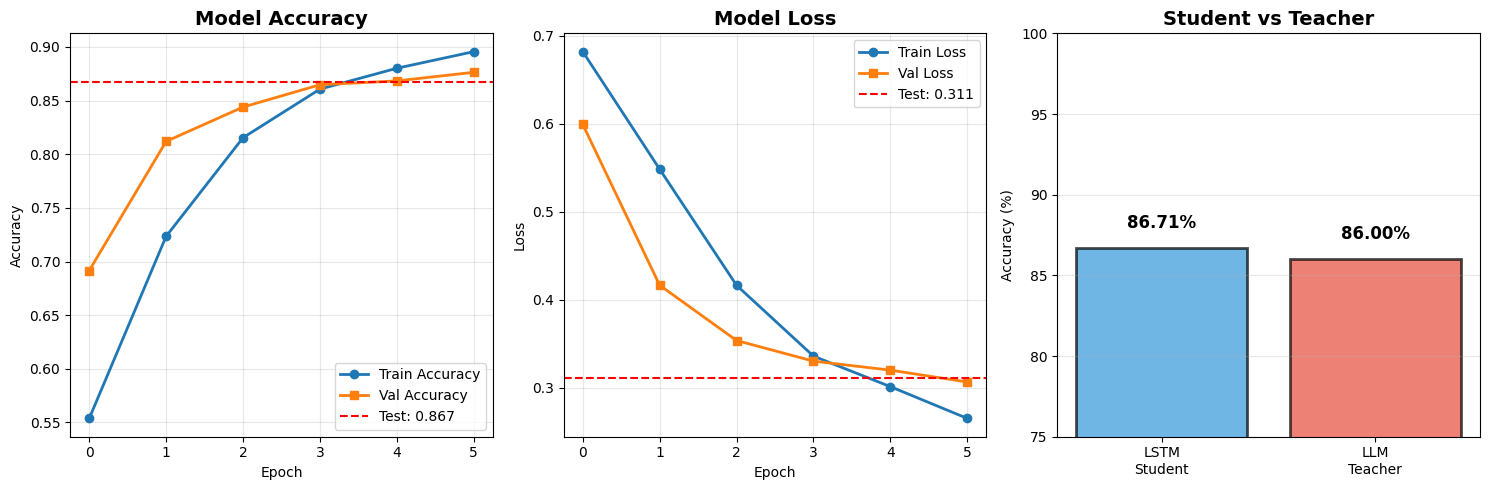

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s', linewidth=2)
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test: {test_acc:.3f}')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test: {test_loss:.3f}')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
models_names = ['LSTM\nStudent', 'LLM\nTeacher']
accuracies = [test_acc * 100, llm_accuracy * 100]
colors = ['#3498db', '#e74c3c']
bars = plt.bar(models_names, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Accuracy (%)')
plt.title('Student vs Teacher', fontsize=14, fontweight='bold')
plt.ylim([75, 100])
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [15]:
print("\n" + "=" * 60)
print("DETAILED VALIDATION SAMPLES")
print("=" * 60)

test_indices = [42, 100, 250, 500, 1000, 2000, 5000, 10000]

lstm_correct = 0
llm_correct = 0
both_correct = 0

for sample_idx in test_indices:
    raw_text = decode_review(x_test[sample_idx])
    lstm_pred = model.predict(x_test_pad[sample_idx:sample_idx+1], verbose=0)[0][0]

    try:
        llm_label = get_llm_sentiment(raw_text[:400])
        llm_result = "Positive" if llm_label == 1 else "Negative"
    except:
        llm_result = "Error"
        llm_label = -1

    actual_label = "Positive" if y_test[sample_idx] == 1 else "Negative"
    lstm_result = "Positive" if lstm_pred > 0.5 else "Negative"

    lstm_match = lstm_result == actual_label
    llm_match = llm_result == actual_label

    if lstm_match:
        lstm_correct += 1
    if llm_match:
        llm_correct += 1
    if lstm_match and llm_match:
        both_correct += 1

    print(f"\n{'='*50}")
    print(f"Sample #{sample_idx}")
    print(f"{'='*50}")
    print(f"Review: {raw_text[:120]}...")
    print(f"\nTRUE: {actual_label}")
    print(f"LSTM: {lstm_result} ({lstm_pred:.3f}) {'✓' if lstm_match else '✗'}")
    print(f"LLM: {llm_result} {'✓' if llm_match else '✗'}")
    print(f"Both Agree: {'YES' if (lstm_match and llm_match) else 'NO'}")

print("\n" + "=" * 60)
print(f"LSTM Correct: {lstm_correct}/{len(test_indices)} ({lstm_correct/len(test_indices)*100:.1f}%)")
print(f"LLM Correct: {llm_correct}/{len(test_indices)} ({llm_correct/len(test_indices)*100:.1f}%)")
print(f"Both Correct: {both_correct}/{len(test_indices)} ({both_correct/len(test_indices)*100:.1f}%)")


DETAILED VALIDATION SAMPLES

Sample #42
Review: ? having been a godzilla fan for many years gamera was to me a cheap ? to ? on the success of ? 1 ? star attack of the m...

TRUE: Negative
LSTM: Negative (0.056) ✓
LLM: Negative ✓
Both Agree: YES

Sample #100
Review: ? a quick glance at the premise of this film would seem to indicate just another dumb ? ? ? ? fest the type where sex ? ...

TRUE: Positive
LSTM: Negative (0.047) ✗
LLM: Positive ✓
Both Agree: NO

Sample #250
Review: ? something i think some people miss about great science fiction is that it ? some part of the future no other theatrica...

TRUE: Positive
LSTM: Positive (0.806) ✓
LLM: Positive ✓
Both Agree: YES

Sample #500
Review: ? this is a funny movie the bob eddie show feel of it could lead to a sequel but i doubt it will make enough money br br...

TRUE: Positive
LSTM: Positive (0.955) ✓
LLM: Positive ✓
Both Agree: YES

Sample #1000
Review: ? ? this is one of the worst movies i have ever seen the ? for the film is bett

In [16]:
print("\n" + "=" * 60)
print("FINAL PERFORMANCE REPORT")
print("=" * 60)

print("\nDATASET:")
print(f"Training: {len(x_train):,} (90%)")
print(f"Validation: {len(x_val):,} (10%)")
print(f"Testing: {len(x_test):,}")

print("\nOPTIMIZED HYPERPARAMETERS:")
print(f"Vocabulary: {VOCAB_SIZE:,}")
print(f"Sequence Length: {MAX_LEN}")
print(f"Embedding Dim: {EMBEDDING_DIM}")
print(f"LSTM Units: {LSTM_UNITS}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {len(history.history['loss'])}")
print(f"Parameters: {model.count_params():,}")

print("\nRESULTS:")
print(f"LSTM Test Accuracy: {test_acc*100:.2f}%")
print(f"LLM Teacher Accuracy: {llm_accuracy*100:.2f}%")
print(f"Knowledge Transfer: {(test_acc/llm_accuracy)*100:.2f}%")


FINAL PERFORMANCE REPORT

DATASET:
Training: 22,500 (90%)
Validation: 2,500 (10%)
Testing: 25,000

OPTIMIZED HYPERPARAMETERS:
Vocabulary: 8,000
Sequence Length: 180
Embedding Dim: 100
LSTM Units: 96
Dropout: 0.35
Learning Rate: 0.0003
Batch Size: 128
Epochs: 6
Parameters: 963,713

RESULTS:
LSTM Test Accuracy: 86.71%
LLM Teacher Accuracy: 86.00%
Knowledge Transfer: 100.83%


In [8]:
import json
import numpy as np

def analyze_comedy_sarcasm(num_samples=20):

    indices = np.random.choice(len(x_test), num_samples, replace=False)
    results = []

    for idx in indices:
        review_text = decode_review(x_test[idx])

        prompt = f"""
        Analyze the following IMDB movie review and return a JSON object with these exact keys:
        1. "movie_title": Infer the likely movie title based on the text (or "Unknown").
        2. "genre": The main genre of the movie.
        3. "is_comedy": boolean (true if Comedy, else false).
        4. "is_sarcastic": boolean (true if the review is sarcastic, else false).
        5. "sarcasm_confidence": float (0.0 to 1.0 confidence score).
        6. "reasoning": Short explanation of sarcasm detection.

        Review:
        {review_text[:1500]}

        JSON Output Format:
        {{
            "movie_title": "...",
            "genre": "...",
            "is_comedy": true,
            "is_sarcastic": true,
            "sarcasm_confidence": 0.9,
            "reasoning": "..."
        }}
        """

        try:
            chat_completion = client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=MODEL_NAME,
                temperature=0.0,
                response_format={"type": "json_object"}
            )

            response_content = chat_completion.choices[0].message.content
            analysis = json.loads(response_content)
            analysis['original_text'] = review_text
            results.append(analysis)
            print(".", end="")
        except Exception as e:
            print("x", end="")

    print("\n\nAnalysis Complete. Filtering for Comedy Movies...\n")

    comedy_reviews = [r for r in results if r.get('is_comedy') == True]

    if not comedy_reviews:
        print("No Comedy movies found in this sample batch.")
    else:
        print(f"Found {len(comedy_reviews)} Comedy movies:\n")
        for i, item in enumerate(comedy_reviews, 1):
            print(f"{i}. Movie: {item.get('movie_title')} | Genre: {item.get('genre')}")
            print(f"   Sarcastic: {item.get('is_sarcastic')} (Confidence: {item.get('sarcasm_confidence')})")
            print(f"   Reasoning: {item.get('reasoning')}")
            print(f"   Review Snippet: \"{item.get('original_text')[:100]}...\"")
            print("-" * 60)

analyze_comedy_sarcasm(num_samples=20)

....................

Analysis Complete. Filtering for Comedy Movies...

Found 5 Comedy movies:

1. Movie: Alvin and the Chipmunks | Genre: Family/Comedy
   Sarcastic: True (Confidence: 0.95)
   Reasoning: The review contains strong negative language and exaggerated expressions, such as 'god i never felt so ? in my whole life', 'piece of crap', and 'please kill me now', which are indicative of sarcasm. The reviewer also uses hyperbolic statements, like 'my head would explode if i saw anything worse than this', to emphasize their dislike for the movie.
   Review Snippet: "? god i never felt so ? in my whole life than with this crap there are so many ways to describe this..."
------------------------------------------------------------
2. Movie: Unknown | Genre: Comedy
   Sarcastic: False (Confidence: 0.2)
   Reasoning: The review is overwhelmingly positive, with the reviewer stating they've watched the movie over 20 times and that it makes them 'fall off my chair'. The tone is enthusias

In [ ]:
import json
import numpy as np
import time
import httpx

def safe_chat_completion(client, **kwargs):
    while True:
        try:
            return client.chat.completions.create(**kwargs)
        except httpx.HTTPStatusError as e:
            if e.response.status_code == 429:
                time.sleep(1.5)
                continue
            raise


def analyze_comedy_sarcasm(num_samples=15):

    indices = np.random.choice(len(x_test), num_samples, replace=False)
    results = []

    print("Processing: ", end="")

    for idx in indices:
        review_text = decode_review(x_test[idx])

        prompt = f"""
You are performing reviewer-focused feedback analysis on IMDB movie reviews.

PRIMARY GOAL:
Extract reviewer intent, feedback quality, sarcasm behavior, and basic movie metadata for comedy-related films.

INTERPRETATION RULES:
- Prioritize reviewer tone and intent over plot description
- Exclude samples with weak or ambiguous movie identification
- Mark is_comedy true only if comedy is a dominant genre, not a sub-genre
- Sarcasm classification must reflect intent, not wording alone

SARCASM TYPES:
- positive: ironic praise, affectionate mockery, camp appreciation
- negative: ridicule, dismissive irony, mocking criticism
- none: literal, sincere, or straightforward tone

EXCLUSION CRITERIA:
- If the movie title or release year cannot be inferred with reasonable confidence, set "exclude": true
- If genre inference is weak or contradictory, set "exclude": true

Return a STRICT JSON object with ONLY the keys listed below.

REQUIRED JSON KEYS:
1. "movie_title": string or null
2. "release_year": integer or null
3. "genre": string
4. "is_comedy": boolean
5. "exclude": boolean
6. "sarcasm_type": string ("positive", "negative", or "none")
7. "sarcasm_confidence": float (0.0–1.0)
8. "reviewer_sentiment": string ("positive", "neutral", or "negative")
9. "reviewer_feedback": string
10. "reasoning": string

REVIEW:
{review_text[:1500]}

JSON OUTPUT ONLY.
"""

        try:
            chat_completion = safe_chat_completion(
                client,
                messages=[{"role": "user", "content": prompt}],
                model=MODEL_NAME,
                temperature=0.0
            )

            message = chat_completion.choices[0].message
            if not message or not message.content:
                raise ValueError("Empty response")

            response_content = message.content.strip()
            analysis = json.loads(response_content)

            analysis["original_text"] = review_text
            results.append(analysis)
            print(".", end="")

            time.sleep(0.5)

        except Exception:
            print("x", end="")

    print("\n\nAnalysis Complete. Filtering for High-Confidence Comedy Feedback...\n")

    filtered_reviews = [
        r for r in results
        if not r.get("exclude")
        and r.get("is_comedy")
        and r.get("sarcasm_confidence", 0.0) >= 0.3
    ]

    if not filtered_reviews:
        print("No valid Comedy reviewer feedback found after filtering.")
        return

    print(f"Found {len(filtered_reviews)} High-Confidence Comedy Reviews:\n")

    for i, item in enumerate(filtered_reviews, 1):
        print(f"{i}. Movie: {item.get('movie_title')} ({item.get('release_year')})")
        print(f"   Genre: {item.get('genre')}")
        print(
            f"   Sarcasm Type: {item.get('sarcasm_type')} "
            f"(Confidence: {item.get('sarcasm_confidence')})"
        )
        print(f"   Reviewer Sentiment: {item.get('reviewer_sentiment')}")
        print(f"   Reviewer Feedback: {item.get('reviewer_feedback')}")
        print(f"   Reasoning: {item.get('reasoning')}")
        print(f"   Review Snippet: \"{item.get('original_text')[:120]}...\"")
        print("-" * 70)


analyze_comedy_sarcasm(num_samples=15)

In [17]:
import json
import numpy as np

def debug_single_review():

    idx = np.random.randint(0, len(x_test))
    review_text = decode_review(x_test[idx])

    prompt = f"""
Return ONLY a valid JSON object.

REQUIRED KEYS:
- movie_title (string or null)
- genre (string)
- is_comedy (boolean)
- exclude (boolean)
- sarcasm_type (string: positive, negative, or none)
- sarcasm_confidence (float 0.0 to 1.0)
- reviewer_sentiment (string)
- reviewer_feedback (string)
- reasoning (string)

REVIEW:
{review_text[:1000]}

JSON ONLY.
"""

    try:
        response = client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=MODEL_NAME,
            temperature=0.0,
            response_format={"type": "json_object"}
        )

        raw = response.choices[0].message.content

        print("\n===== RAW MODEL OUTPUT =====")
        print(raw)
        print("===== END RAW OUTPUT =====\n")

        parsed = json.loads(raw)

        print("===== PARSED JSON =====")
        for k, v in parsed.items():
            print(f"{k}: {v}")
        print("===== END PARSED JSON =====")

    except Exception as e:
        print("\n===== ERROR =====")
        print(type(e).__name__, ":", e)
        print("===== END ERROR =====")


debug_single_review()



===== RAW MODEL OUTPUT =====
{
  "movie_title": null,
   "genre": "Thriller",
   "is_comedy": false,
   "exclude": false,
   "sarcasm_type": "none",
   "sarcasm_confidence": 0.0,
   "reviewer_sentiment": "Positive",
   "reviewer_feedback": "The reviewer enjoyed the film and appreciated the complexity of the main character's personality and backstory.",
   "reasoning": "The reviewer provides a detailed analysis of the main character's actions and motivations, highlighting the script's intentional ambiguity and the character's emotional response to traumatic events."
}
===== END RAW OUTPUT =====

===== PARSED JSON =====
movie_title: None
genre: Thriller
is_comedy: False
exclude: False
sarcasm_type: none
sarcasm_confidence: 0.0
reviewer_sentiment: Positive
reviewer_feedback: The reviewer enjoyed the film and appreciated the complexity of the main character's personality and backstory.
reasoning: The reviewer provides a detailed analysis of the main character's actions and motivations, hi